In [1]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

Load all data into memory; loading both the separate weekly and daily files, and the continuing weekly and daily file.

In [2]:
start_date = "2004-01-01"
end_date = "2020-06-03"
keyword = "debt"

In [3]:
monthly = pd.read_csv(f"data/{keyword}/{start_date}_{end_date}/unadjusted/monthly_{keyword}.csv")

In [4]:
i = 0
while True:
    try:
        if i == 0:
            weekly = pd.read_csv(
                f"data/{keyword}/{start_date}_{end_date}/unadjusted/weekly/{i}_weekly_{keyword}.csv")
        else:
            temp = pd.read_csv(
                f"data/{keyword}/{start_date}_{end_date}/unadjusted/weekly/{i}_weekly_{keyword}.csv")
            temp = temp.replace(0, 1)
            weekly = weekly.append(temp, ignore_index=True)
    except:
        break

    i += 1

In [5]:
i = 0
while True:
    try:
        if i == 0:
            daily = pd.read_csv(
                f"data/{keyword}/{start_date}_{end_date}/unadjusted/daily/{i}_daily_{keyword}.csv")
        else:
            temp = pd.read_csv(
                f"data/{keyword}/{start_date}_{end_date}/unadjusted/daily/{i}_daily_{keyword}.csv")
            temp = temp.replace(0, 1)
            daily = daily.append(temp, ignore_index=True)
    except:
        break

    i += 1

In [6]:
monthly = monthly.replace(0, 1)
weekly = weekly.replace(0, 1)
daily = daily.replace(0, 1)

## Weekly

Computing percentage change for each relative frequency.

In [7]:
weekly["percentage_change"] = 1 + weekly["relative_frequency"].pct_change()

Get the adjusted values for each percentage change.

In [8]:
weekly["adjusted"] = ""

In [9]:
i = 0  
while True:
    try:
        weekly.loc[i * 261, "adjusted"] = monthly.loc[i * 60, "relative_frequency"]
        i += 1
    except:
        break

In [10]:
for i in range(len(weekly)):
    if weekly["adjusted"][i] == "":
        prc = float(weekly["percentage_change"][i])
        prev_value = float(weekly["adjusted"][i-1])
        new_value = prev_value * prc
        weekly.loc[i, "adjusted"] = new_value

## Daily

Computing relative change for each relative frequency.

In [11]:
daily["percentage_change"] = 1 + daily["relative_frequency"].pct_change()

In [12]:
daily["adjusted"] = ""

Every six months a data point from the weekly data has to be added to daily.

In [13]:
start_dt = datetime.date.fromisoformat(start_date)
end = datetime.date.fromisoformat(end_date)

In [14]:
start_dt = datetime.date.fromisoformat(start_date)
end_dt = start_dt + relativedelta(months=+6)

i = 0
while True:
    imported = False
    while True:
        if i >= len(daily):
            break
        
        if not imported:
            try:
                daily.loc[i, "adjusted"] = weekly["adjusted"].where(weekly["date"] == str(start_dt)).dropna().values[0]
                imported = True
            except:
                pass
        else:
            prc = float(daily["percentage_change"][i])
            prev_value = float(daily["adjusted"][i-1])
            new_value = prev_value * prc
            daily.loc[i, "adjusted"] = new_value
        
        start_dt += relativedelta(days=+1)
        i += 1
        
        if start_dt >= end_dt:
            break
    
    start_dt = end_dt
    end_dt += relativedelta(months=+6)
    
    if start_dt > end:
        break

Also adjust all previous values.

In [15]:
i = 0
while True:
    if i >= len(daily) - 1:
        break
    
    if daily.loc[i, "adjusted"] == "":
        j = 0
        while True:
            if daily.loc[i+j, "adjusted"] == "":
                j += 1
            else:
                prc = float(daily["percentage_change"][i+j])
                new_value = float(daily["adjusted"][i+j])
                prev_value = int(new_value / prc)
                daily.loc[i+j-1, "adjusted"] = prev_value
                
                j -= 1
            
            if j <= 0:
                break

    i += 1

In [16]:
daily = daily.drop(["relative_frequency", "percentage_change"], axis=1)

In [17]:
daily["adjusted"] = daily["adjusted"].astype(int)

In [18]:
daily.to_csv(f"data/{keyword}/{start_date}_{end_date}/{keyword}_adjusted.csv", index=False)

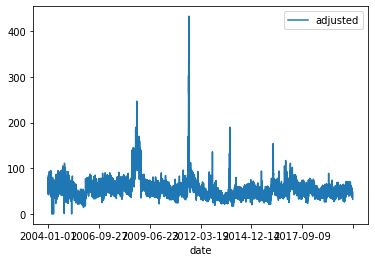

In [19]:
daily.plot("date")

In [20]:
daily

,date,adjusted
0,2004-01-01,45
1,2004-01-02,80
2,2004-01-03,54
3,2004-01-04,42
4,2004-01-05,85
...,...,...
5991,2020-05-27,47
5992,2020-05-28,49
5993,2020-05-29,43
5994,2020-05-30,36
